
--- Statystyki z tripinfo.xml ---
Średni czas podróży: 57.96 s
Średnia długość trasy: 333.87 m
Średni czas oczekiwania na światłach: 22.04 s
Średnia prędkość wszystkich pojazdów: 24.92 km/h


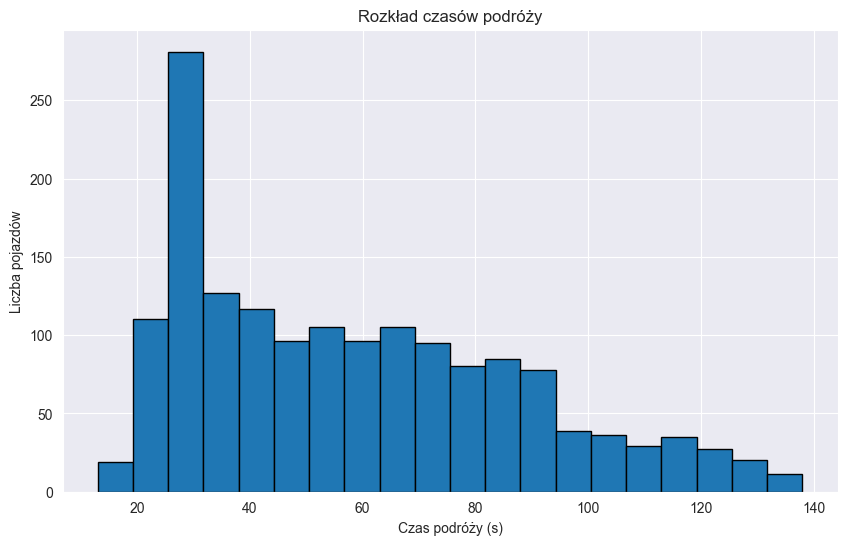

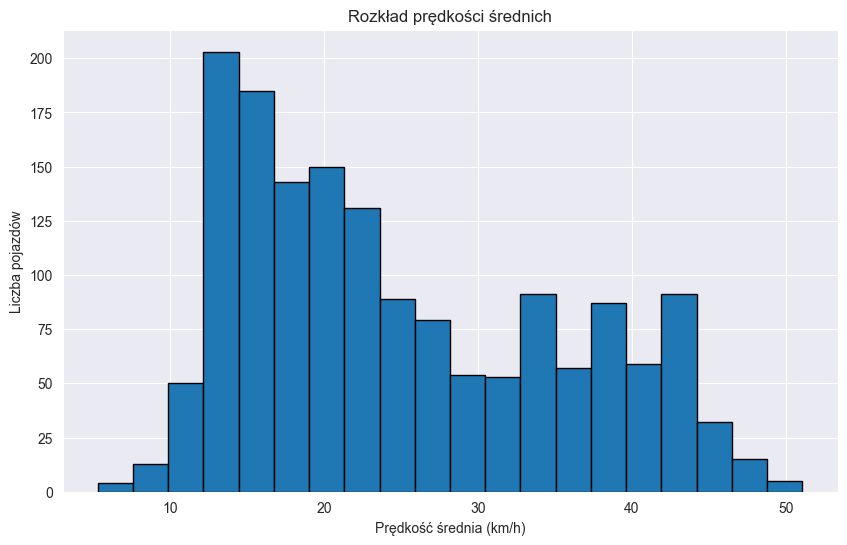


--- Statystyki z summary.xml ---
Łączna liczba pojazdów wpuszczonych: 1613
Łączna liczba pojazdów, które dotarły do celu: 1591
Średnia prędkość w całej symulacji: 5.60 m/s = 20.18 km/h
Czas trwania symulacji: 3599.00 s

--- Statystyki z queues.xml ---
Maksymalna długość kolejki (na dowolnym pasie w dowolnym czasie): 88.57 m
Średnia maksymalna długość kolejki (po wszystkich pasach): 28.42 m
Średni czas oczekiwania w kolejkach (średnia po wszystkich pasach i krokach czasowych): 25.19 s
Średnia liczba pojazdów w kolejkach (przybliżona): 4.54


In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

def analizuj_tripinfo(plik):
    """Analizuje plik tripinfo.xml i wyświetla podstawowe statystyki."""
    tree = ET.parse(plik)
    root = tree.getroot()
    czasy_podrozy = []
    dlugosci_tras = []
    czasy_oczekiwania = []
    predkosci_srednie = []

    for trip in root.findall('.//tripinfo'):
        czas_podrozy = trip.get('duration')
        dlugosc_trasy = trip.get('routeLength')
        czas_oczekiwania = trip.get('waitingTime')
        if czas_podrozy!=0:
            predkosc_srednia = float(dlugosc_trasy)/float(czas_podrozy) * 3.6
        else:
            predkosc_srednia = None
    
        if czas_podrozy is not None and dlugosc_trasy is not None and czas_oczekiwania is not None and predkosc_srednia is not None:
            czasy_podrozy.append(float(czas_podrozy))
            dlugosci_tras.append(float(dlugosc_trasy))
            czasy_oczekiwania.append(float(czas_oczekiwania))
            predkosci_srednie.append(float(predkosc_srednia))

    if czasy_podrozy:
        df = pd.DataFrame({
            'czas_podrozy': czasy_podrozy,
            'dlugosc_trasy': dlugosci_tras,
            'czas_oczekiwania': czasy_oczekiwania,
            'predkosc_srednia': predkosci_srednie
        })

        print("\n--- Statystyki z tripinfo.xml ---")
        print(f"Średni czas podróży: {df['czas_podrozy'].mean():.2f} s")
        print(f"Średnia długość trasy: {df['dlugosc_trasy'].mean():.2f} m")
        print(f"Średni czas oczekiwania na światłach: {df['czas_oczekiwania'].mean():.2f} s")
        print(f"Średnia prędkość wszystkich pojazdów: {df['predkosc_srednia'].mean():.2f} km/h")

        # Wizualizacja rozkładu czasów podróży
        plt.figure(figsize=(10, 6))
        plt.hist(df['czas_podrozy'], bins=20, edgecolor='black')
        plt.title('Rozkład czasów podróży')
        plt.xlabel('Czas podróży (s)')
        plt.ylabel('Liczba pojazdów')
        plt.grid(True)
        plt.show()

        # Wizualizacja rozkładu prędkości średnich
        plt.figure(figsize=(10, 6))
        plt.hist(df['predkosc_srednia'], bins=20, edgecolor='black')
        plt.title('Rozkład prędkości średnich')
        plt.xlabel('Prędkość średnia (km/h)')
        plt.ylabel('Liczba pojazdów')
        plt.grid(True)
        plt.show()
    else:
        print("\n--- Brak danych tripinfo do analizy ---")



def analizuj_summary(plik):
    """Analizuje plik summary.xml i wyświetla podsumowanie symulacji."""
    tree = ET.parse(plik)
    root = tree.getroot()

    total_loaded = 0
    total_ended = 0
    total_arrived = 0 
    mean_speed = 0.0
    time = 0.0
    num_steps = 0

    for step in root.findall('.//step'):
        try:
            total_loaded = max(total_loaded, int(step.get('loaded', 0)))
            total_ended = max(total_ended, int(step.get('ended', 0)))
            total_arrived = max(total_arrived, int(step.get('arrived', 0)))
            mean_speed += float(step.get('meanSpeed', 0))
            time = max(time, float(step.get('time', 0)))
            num_steps += 1
        except (ValueError, TypeError) as e:
            print(f"Błąd podczas parsowania kroku w summary.xml: {e}")
            continue


    print("\n--- Statystyki z summary.xml ---")
    print(f"Łączna liczba pojazdów wpuszczonych: {total_loaded}")
    print(f"Łączna liczba pojazdów, które dotarły do celu: {total_ended}")
    if num_steps > 0:
        print(f"Średnia prędkość w całej symulacji: {mean_speed / num_steps:.2f} m/s = {mean_speed * 3.6 / num_steps:.2f} km/h")
    else:
        print("Brak kroków do obliczenia średniej prędkości.")
    print(f"Czas trwania symulacji: {time:.2f} s")

def analizuj_queues(plik):
    """Analizuje plik queues.xml i wyświetla statystyki kolejek."""
    tree = ET.parse(plik)
    root = tree.getroot()

    max_queue_lengths = {}
    total_waiting_time = 0
    total_vehicles_in_queue = 0
    lane_counts = {}

    for data in root.findall('.//data'):
        lanes_element = data.find('./lanes')
        if lanes_element is not None:
            for lane in lanes_element.findall('./lane'):
                lane_id = lane.get('id')
                queueing_length = float(lane.get('queueing_length', 0))
                waiting_time = float(lane.get('queueing_time', 0))

                max_queue_lengths[lane_id] = max(max_queue_lengths.get(lane_id, 0), queueing_length)
                total_waiting_time += waiting_time
                total_vehicles_in_queue += (queueing_length / 6.0) if queueing_length > 0 else 0 # Przybliżona liczba pojazdów (zakładając średnią długość pojazdu ~6m)
                lane_counts[lane_id] = lane_counts.get(lane_id, 0) + 1

    if max_queue_lengths:
        print("\n--- Statystyki z queues.xml ---")
        max_overall_queue_length = max(max_queue_lengths.values()) if max_queue_lengths.values() else 0
        mean_max_queue_length = sum(max_queue_lengths.values()) / len(max_queue_lengths) if max_queue_lengths else 0
        print(f"Maksymalna długość kolejki (na dowolnym pasie w dowolnym czasie): {max_overall_queue_length:.2f} m")
        print(f"Średnia maksymalna długość kolejki (po wszystkich pasach): {mean_max_queue_length:.2f} m")

    if total_waiting_time > 0 and sum(lane_counts.values()) > 0:
        mean_waiting_time = total_waiting_time / sum(lane_counts.values())
        print(f"Średni czas oczekiwania w kolejkach (średnia po wszystkich pasach i krokach czasowych): {mean_waiting_time:.2f} s")

    if total_vehicles_in_queue > 0 and sum(lane_counts.values()) > 0:
        mean_vehicles_in_queue = total_vehicles_in_queue / sum(lane_counts.values())
        print(f"Średnia liczba pojazdów w kolejkach (przybliżona): {mean_vehicles_in_queue:.2f}")
    elif max_queue_lengths:
        print("Brak danych o czasie oczekiwania lub długości kolejek do obliczenia średniej.")
    else:
        print("\n--- Brak danych o kolejkach w queues.xml ---")


def main():
    plik_tripinfo = 'tripinfo_rano.xml'
    plik_summary = 'summary_rano.xml'
    plik_queues = 'queues_rano.xml'

    analizuj_tripinfo(plik_tripinfo)
    analizuj_summary(plik_summary)
    analizuj_queues(plik_queues)

if __name__ == "__main__":
    main()